# clean code

In [39]:
print(open('./datathon/.git/config', 'r').read())

[core]
	repositoryformatversion = 0
	filemode = true
	bare = false
	logallrefupdates = true
[remote "origin"]
	url = https://github.com/Emory-HITI/datathon.git
	fetch = +refs/heads/*:refs/remotes/origin/*
[branch "main"]
	remote = origin
	merge = refs/heads/main



In [1]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from tableone import tableone
import matplotlib.pyplot as plt

# dataset checking

In [2]:
def dataframe_stats(df, title: str or None = None):
    if title is not None:
        print(f"\n{title}")
        
    num_patients = df.empi_anon.nunique()
    num_exams = df.acc_anon.nunique()
    
    print(f"Patients: {num_patients}")
    print(f"Exams: {num_exams}")
    
    if 'png_path' in df.columns:
        print(f"Images: {len(df)}")
        
def plot_feature_density(feature, depth: int = 1, cmap: str = 'viridis'):
    # get colormap object
    cm = plt.get_cmap(cmap)
    
    # create the density plot
    axis = feature.plot.density(
        xlim=(feature.min(), feature.max()), 
        color=cm(0.0)
    )

    # get mean and standard deviation for age
    var_mean = feature.mean()
    var_std = feature.std()

    line = axis.get_lines()[0]

    # extract x and y data from the line object
    x = line.get_xdata()
    y = line.get_ydata()
    
    # plot mean
    axis.axvline(var_mean, color=cm(1.0), linestyle='--', label='Mean')
    
    # iterate over std depth levels
    for i in range(depth, 0, -1):
        # get bounds of std interval
        sigma_min, sigma_max = var_mean-(i*var_std), var_mean+(i*var_std)
        
        # mask array between bounds
        array_mask = (x >= sigma_min) & (x <= sigma_max)
        
        # plot std interval
        sigma_value = 0.7 / i
        axis.fill_between(x, y, where=array_mask, color=cm(sigma_value), alpha=0.3, label=f'{i}σ')
        
    ax.legend()
        
    return axis

In [3]:
base_directory = "/embed"
mag_path = base_directory + "/tables/embed_datathon_magview_full.csv"
meta_path = base_directory + "/tables/embed_datathon_metadata_full.csv"

# load clinical data from magview
mag_df = pd.read_csv(mag_path)
dataframe_stats(mag_df, 'magview:')

# load image metadata
meta_df = pd.read_csv(meta_path)
dataframe_stats(meta_df, 'metadata:')

/tmp/ipykernel_144917/2146351998.py:6: DtypeWarning: Columns (31,34,36,51,52,53,54,56,57,58,59,60,62,66,79,81,84,87,88,96,114) have mixed types. Specify dtype option on import or set low_memory=False.
  mag_df = pd.read_csv(mag_path)



magview:
Patients: 115883
Exams: 364733


/tmp/ipykernel_144917/2146351998.py:10: DtypeWarning: Columns (74,103,104,113,114,115,116,117,118,119,121,128,130,131,132,133,134,136,141,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_df = pd.read_csv(meta_path)



metadata:
Patients: 115894
Exams: 364733
Images: 2403687


In [4]:
# get table of asessments
mag_df['exam_type'] = 'Other'
mag_df.loc[mag_df['desc'].str.contains('screen', case=False), 'exam_type'] = 'Screening'
mag_df.loc[mag_df['desc'].str.contains('diag', case=False), 'exam_type'] = 'Diagnostic'
tableone(mag_df, ['asses'], groupby=['exam_type'])

Grouped by exam_type                                            
                            Missing        Overall    Diagnostic      Screening
n                                           408464        112277         296187
asses, n (%) A                    0   57479 (14.1)    2780 (2.5)   54699 (18.5)
             B                        75969 (18.6)  43031 (38.3)   32938 (11.1)
             K                          2031 (0.5)    2018 (1.8)       13 (0.0)
             M                          1639 (0.4)    1634 (1.5)        5 (0.0)
             N                       228979 (56.1)  20619 (18.4)  208360 (70.3)
             P                         27444 (6.7)  27365 (24.4)       79 (0.0)
             S                         14817 (3.6)  14728 (13.1)       89 (0.0)
             X                           106 (0.0)     102 (0.1)        4 (0.0)

# checking percentage of diagnostic exams that were biopsied

In [19]:
# ensure our study date column is read as a datetime
mag_df['study_date_anon'] = pd.to_datetime(mag_df['study_date_anon'], errors='coerce', format= '%Y-%m-%d')

# get diagnostic exams with BIRADS 1/2/4/5
mag_diag_pos_df = mag_df[mag_df.asses.isin(['N', 'B', 'S','M']) & mag_df.desc.str.contains('diag', case=False)]

# get relevant columns to prepare for merge with screening exams
diag_cols = ['empi_anon', 'acc_anon', 'numfind', 'side', 'study_date_anon', 'asses']
mag_diag_pos_reduced_df = mag_diag_pos_df[diag_cols]

dataframe_stats(mag_diag_pos_reduced_df, 'mag_diag_pos_reduced_df:')

# rename columns to prepare for the merge
mag_diag_pos_reduced_df.columns = [
    'empi_anon', 
    'acc_anon_diag', 
    'diag_num', 
    'diag_side', 
    'diag_study_date', 
    'diag_asses'
]

# get dataframe of screening exams
mag_scr_df = mag_df[mag_df.desc.str.contains('screen', case=False)]

# left merge on empi_anon
mag_scr_pos_df = mag_diag_pos_reduced_df.merge(mag_scr_df, on='empi_anon', how='left')

dataframe_stats(mag_scr_pos_df, 'mag_scr_pos_df:')

# keep screening exams with the same laterality as the subsequent diagnostic exams
mag_scr_pos_df = mag_scr_pos_df.loc[(mag_scr_pos_df.side == mag_scr_pos_df.diag_side)]

dataframe_stats(mag_scr_pos_df, 'mag_scr_pos_df: (after side filtering)')

# get time difference between diagnostic and screening exams
mag_scr_pos_df['study_date_diff'] = mag_scr_pos_df.diag_study_date - mag_scr_pos_df.study_date_anon

# keep only screening exams with a time diff
mag_scr_pos_rel_df = mag_scr_pos_df.loc[(mag_scr_pos_df.study_date_diff.dt.days >= 0) & 
                                        (mag_scr_pos_df.study_date_diff.dt.days <= 360)]

dataframe_stats(mag_scr_pos_rel_df, 'mag_scr_pos_rel_df: (after date filtering)')

# define a list of columns from meta_df to retain
meta_cols = ['acc_anon', 'ImageLateralityFinal', 'ViewPosition', 'png_path']

# filter the dataframe to only contain 2D images
meta_2d_df = meta_df[meta_df.FinalImageType == '2D']

# merge positive magview dataframe with metadata
meta_2d_scr_pos_df = mag_scr_pos_rel_df.merge(
    meta_2d_df[meta_cols], 
    how='inner', 
    left_on=['acc_anon', 'side'],
    right_on=['acc_anon', 'ImageLateralityFinal']
)
dataframe_stats(mag_scr_pos_rel_df, 'mag_scr_pos_rel_df')
dataframe_stats(meta_2d_scr_pos_df, 'meta_2d_scr_pos_df: (merged)')


mag_diag_pos_reduced_df:
Patients: 44050
Exams: 62221

mag_scr_pos_df:
Patients: 44050
Exams: 103890

mag_scr_pos_df: (after side filtering)
Patients: 25149
Exams: 38750

mag_scr_pos_rel_df: (after date filtering)
Patients: 20754
Exams: 23064

mag_scr_pos_rel_df
Patients: 20754
Exams: 23064

meta_2d_scr_pos_df: (merged)
Patients: 20530
Exams: 22811
Images: 100987


# filtering for biopsies with severities

In [20]:
meta_2d_scr_pos_df_breastC = meta_2d_scr_pos_df[meta_2d_scr_pos_df['path_severity'] != 5]
meta_2d_scr_pos_df_breastC.path_severity.value_counts()

path_severity
4.0    15669
0.0     8545
2.0     7478
1.0     4138
3.0      155
Name: count, dtype: int64

In [21]:
cancer_label = []
for i in range(len(meta_2d_scr_pos_df_breastC)):
    path_sev = meta_2d_scr_pos_df_breastC['path_severity'].iloc[i]
    if path_sev == 0 or path_sev == 1:
        cancer_label.append(1)
    elif path_sev in [2,3,4]:
        cancer_label.append(0)
    else:
        cancer_label.append(-1)
meta_2d_scr_pos_df_breastC['cancer'] = cancer_label
meta_2d_scr_pos_df_breastC['cancer'].value_counts()
# -1 being BIRADS 1/2 at diagnostic
# 0 being benign from BIRADS 4/5
# 1 being malignant from BIRADS 4/5

/tmp/ipykernel_144917/562364200.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_2d_scr_pos_df_breastC['cancer'] = cancer_label


cancer
-1    64738
 0    23302
 1    12683
Name: count, dtype: int64

In [22]:
# getting proportional rates diagnosis findings - for African American or Black patients
meta_2d_scr_pos_df_breastC[(meta_2d_scr_pos_df_breastC['ETHNICITY_DESC'] == 'African American or Black')]['cancer'].value_counts(normalize=True)

cancer
-1    0.605581
 0    0.274646
 1    0.119773
Name: proportion, dtype: float64

In [23]:
# getting proportional rates of cancer findings per biopsy - for African American or Black patients
meta_2d_scr_pos_df_breastC[(meta_2d_scr_pos_df_breastC['ETHNICITY_DESC'] == 'African American or Black') & (meta_2d_scr_pos_df_breastC['cancer'] != -1)]['cancer'].value_counts(normalize=True)

cancer
0    0.696331
1    0.303669
Name: proportion, dtype: float64

In [24]:
# getting incidence of cancer rates - for African American or Black patients
len(meta_2d_scr_pos_df_breastC[(meta_2d_scr_pos_df_breastC['ETHNICITY_DESC'] == 'African American or Black') & (meta_2d_scr_pos_df_breastC['cancer'] == 1)])/len((meta_2d_scr_pos_df_breastC['ETHNICITY_DESC'] == 'African American or Black'))

0.05752410075156618

In [25]:
# getting proportional rates diagnosis findings - for Caucasian or White
meta_2d_scr_pos_df_breastC[(meta_2d_scr_pos_df_breastC['ETHNICITY_DESC'] == 'Caucasian or White')]['cancer'].value_counts(normalize=True)

cancer
-1    0.656782
 0    0.190858
 1    0.152360
Name: proportion, dtype: float64

In [26]:
# getting proportional rates of cancer findings per biopsy - for Caucasian or White
meta_2d_scr_pos_df_breastC[(meta_2d_scr_pos_df_breastC['ETHNICITY_DESC'] == 'Caucasian or White') & (meta_2d_scr_pos_df_breastC['cancer'] != -1)]['cancer'].value_counts(normalize=True)

cancer
0    0.556084
1    0.443916
Name: proportion, dtype: float64

In [27]:
# getting incidence of cancer rates - for Caucasian or White
len(meta_2d_scr_pos_df_breastC[(meta_2d_scr_pos_df_breastC['ETHNICITY_DESC'] == 'Caucasian or White') & (meta_2d_scr_pos_df_breastC['cancer'] == 1)])/len((meta_2d_scr_pos_df_breastC['ETHNICITY_DESC'] == 'Caucasian or White'))

0.06208115326191634

In [28]:
team3_dataset = meta_2d_scr_pos_df_breastC[meta_2d_scr_pos_df_breastC['cancer'] != -1]
team3_dataset

,empi_anon,acc_anon_diag,diag_num,diag_side,diag_study_date,diag_asses,Unnamed: 0,Unnamed: 0.1,index,Unnamed: 0.1.1,...,path_severity,total_L_find,total_R_find,first_3_zip,exam_type,study_date_diff,ImageLateralityFinal,ViewPosition,png_path,cancer
0,70270720,2327819077874596,1,L,2012-10-05,S,240.0,240.0,240.0,2840.0,...,4.0,1.0,0.0,303.0,Screening,31 days,L,CC,/data/mammo/png/cohort_1/extracted-images/eb88...,0
1,70270720,2327819077874596,1,L,2012-10-05,S,240.0,240.0,240.0,2840.0,...,4.0,1.0,0.0,303.0,Screening,31 days,L,MLO,/data/mammo/png/cohort_1/extracted-images/eb88...,0
2,70270720,2327819077874596,1,L,2012-10-05,S,240.0,240.0,240.0,2840.0,...,4.0,1.0,0.0,303.0,Screening,31 days,L,MLO,/data/mammo/png/cohort_1/extracted-images/eb88...,0
52,63915451,8730500884382410,1,L,2013-03-05,S,560.0,560.0,560.0,6431.0,...,2.0,2.0,3.0,303.0,Screening,18 days,L,CC,/data/mammo/png/cohort_1/extracted-images/6e25...,0
53,63915451,8730500884382410,1,L,2013-03-05,S,560.0,560.0,560.0,6431.0,...,2.0,2.0,3.0,303.0,Screening,18 days,L,MLO,/data/mammo/png/cohort_1/extracted-images/6e25...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100976,43608839,7109438307107557,1,R,2019-10-28,S,424545.0,424545.0,424545.0,415806.0,...,0.0,0.0,2.0,300.0,Screening,49 days,R,MLO,/data/mammo/png/cohort_10/extracted-images/979...,1
100977,43608839,7109438307107557,1,R,2019-10-28,S,424546.0,424546.0,424546.0,415807.0,...,4.0,0.0,2.0,300.0,Screening,49 days,R,CC,/data/mammo/png/cohort_10/extracted-images/979...,0
100978,43608839,7109438307107557,1,R,2019-10-28,S,424546.0,424546.0,424546.0,415807.0,...,4.0,0.0,2.0,300.0,Screening,49 days,R,MLO,/data/mammo/png/cohort_10/extracted-images/979...,0
100983,50020271,6690811192177295,1,L,2021-01-30,B,424834.0,424834.0,424834.0,419098.0,...,4.0,1.0,0.0,302.0,Screening,291 days,L,MLO,/data/mammo/png/cohort_10/extracted-images/d15...,0


In [29]:
team3_dataset.columns

Index(['empi_anon', 'acc_anon_diag', 'diag_num', 'diag_side',
       'diag_study_date', 'diag_asses', 'Unnamed: 0', 'Unnamed: 0.1', 'index',
       'Unnamed: 0.1.1',
       ...
       'path_severity', 'total_L_find', 'total_R_find', 'first_3_zip',
       'exam_type', 'study_date_diff', 'ImageLateralityFinal', 'ViewPosition',
       'png_path', 'cancer'],
      dtype='object', length=126)

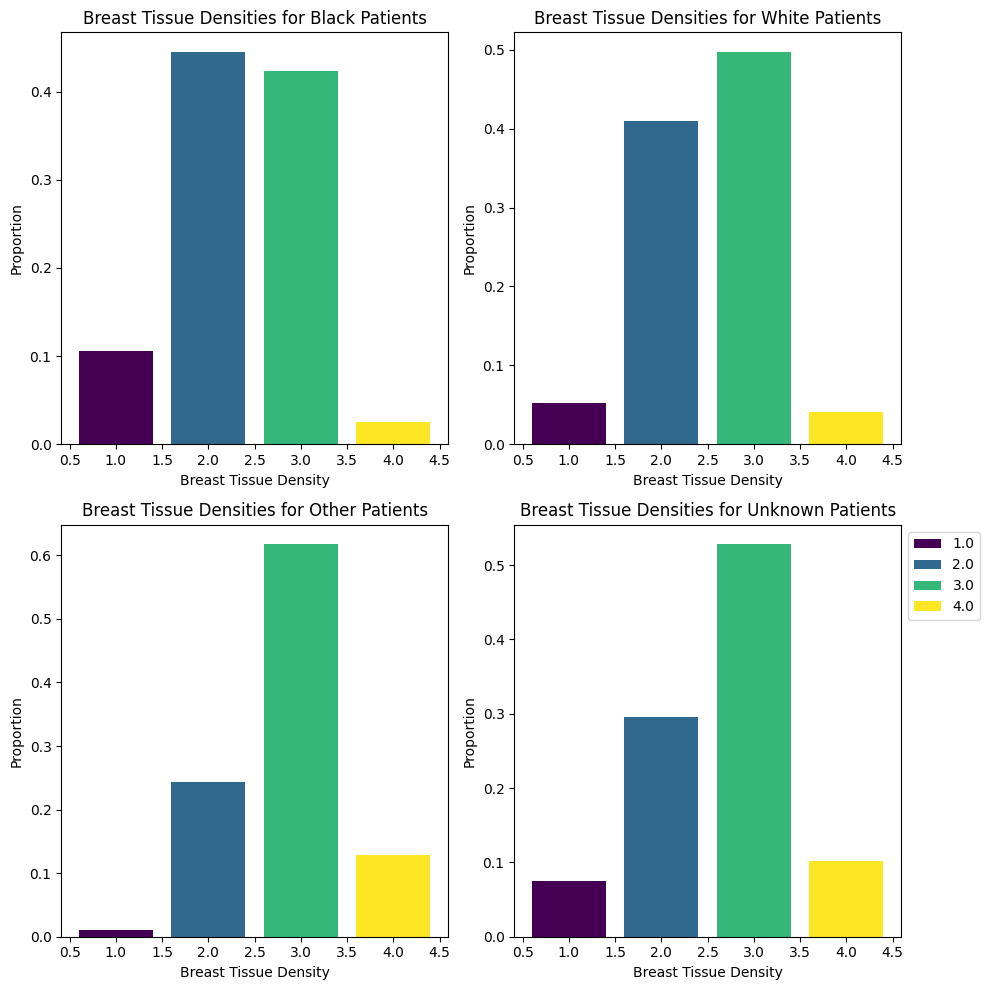

In [35]:
# create the 'patient_race' column and set the default value to 'Unknown'
team3_dataset.loc[:, 'patient_race'] = 'Unknown'

# code races for Black and white patients
team3_dataset.loc[team3_dataset['ETHNICITY_DESC'] == 'African American or Black', 'patient_race'] = 'Black'
team3_dataset.loc[team3_dataset['ETHNICITY_DESC'] == 'Caucasian or White', 'patient_race'] = 'White'

# consolidate other patient race categories
other_race_categories = [
    'American Indian or Alaskan Native', 
    'Asian', 
    'Hispanic', 
    'Multiple', 
    'Native Hawaiian or Other Pacific Islander'
]
team3_dataset.loc[team3_dataset['ETHNICITY_DESC'].isin(other_race_categories), 'patient_race'] = 'Other'

# list of unique values for patient race
race_descs = team3_dataset['patient_race'].dropna().unique()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.ravel()

colors = plt.cm.viridis(np.linspace(0.0, 1.0, team3_dataset['tissueden'].dropna().nunique()))
color_map = dict(zip(race_descs, colors))

bar_list = []

for i, race_desc in enumerate(race_descs):
    rel_densities = team3_dataset.loc[team3_dataset['patient_race'] == race_desc, 'tissueden'].dropna()
    
    labels, counts = np.unique(rel_densities, return_counts=True)
    
    bar_colors = [color_map[label] for label in race_descs]
    
    props = [c/len(rel_densities) for c in counts]
    
    curr_bar = axs[i].bar(labels, props, color=bar_colors)
    axs[i].set_title(f'Breast Tissue Densities for {race_desc} Patients')
    axs[i].set_ylabel('Proportion')
    axs[i].set_xlabel('Breast Tissue Density')
    
    bar_list.extend(curr_bar)
    
plt.legend(curr_bar, labels, loc="upper left", bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()

In [15]:
team3_dataset[team3_dataset['acc_anon_diag'] == 7109438307107557]

,empi_anon,acc_anon_diag,diag_num,diag_side,diag_study_date,diag_asses,Unnamed: 0,Unnamed: 0.1,index,Unnamed: 0.1.1,...,path_severity,total_L_find,total_R_find,first_3_zip,exam_type,study_date_diff,ImageLateralityFinal,ViewPosition,png_path,cancer
35019,43608839,7109438307107557,1,R,2019-10-28,S,424545.0,424545.0,424545.0,415806.0,...,0.0,0.0,2.0,300.0,Screening,49 days,R,CC,/data/mammo/png/cohort_10/extracted-images/979...,1
35020,43608839,7109438307107557,1,R,2019-10-28,S,424545.0,424545.0,424545.0,415806.0,...,0.0,0.0,2.0,300.0,Screening,49 days,R,MLO,/data/mammo/png/cohort_10/extracted-images/979...,1
35021,43608839,7109438307107557,1,R,2019-10-28,S,424546.0,424546.0,424546.0,415807.0,...,4.0,0.0,2.0,300.0,Screening,49 days,R,CC,/data/mammo/png/cohort_10/extracted-images/979...,0
35022,43608839,7109438307107557,1,R,2019-10-28,S,424546.0,424546.0,424546.0,415807.0,...,4.0,0.0,2.0,300.0,Screening,49 days,R,MLO,/data/mammo/png/cohort_10/extracted-images/979...,0
35023,43608839,7109438307107557,1,R,2019-10-28,S,424545.0,424545.0,424545.0,415806.0,...,0.0,0.0,2.0,300.0,Screening,49 days,R,CC,/data/mammo/png/cohort_10/extracted-images/979...,1
35024,43608839,7109438307107557,1,R,2019-10-28,S,424545.0,424545.0,424545.0,415806.0,...,0.0,0.0,2.0,300.0,Screening,49 days,R,MLO,/data/mammo/png/cohort_10/extracted-images/979...,1
35025,43608839,7109438307107557,1,R,2019-10-28,S,424546.0,424546.0,424546.0,415807.0,...,4.0,0.0,2.0,300.0,Screening,49 days,R,CC,/data/mammo/png/cohort_10/extracted-images/979...,0
35026,43608839,7109438307107557,1,R,2019-10-28,S,424546.0,424546.0,424546.0,415807.0,...,4.0,0.0,2.0,300.0,Screening,49 days,R,MLO,/data/mammo/png/cohort_10/extracted-images/979...,0


In [16]:
team3_dataset[['vtype', 'exam_type', 'ImageLateralityFinal', 'ViewPosition', 'png_path']]

,vtype,exam_type,ImageLateralityFinal,ViewPosition,png_path
0,S,Screening,L,CC,/data/mammo/png/cohort_1/extracted-images/eb88...
1,S,Screening,L,MLO,/data/mammo/png/cohort_1/extracted-images/eb88...
2,S,Screening,L,MLO,/data/mammo/png/cohort_1/extracted-images/eb88...
7,S,Screening,L,CC,/data/mammo/png/cohort_1/extracted-images/6e25...
8,S,Screening,L,MLO,/data/mammo/png/cohort_1/extracted-images/6e25...
...,...,...,...,...,...
35022,S,Screening,R,MLO,/data/mammo/png/cohort_10/extracted-images/979...
35023,S,Screening,R,CC,/data/mammo/png/cohort_10/extracted-images/979...
35024,S,Screening,R,MLO,/data/mammo/png/cohort_10/extracted-images/979...
35025,S,Screening,R,CC,/data/mammo/png/cohort_10/extracted-images/979...


In [17]:
pt = team3_dataset[team3_dataset['empi_anon'] == 70270720]
pt

,empi_anon,acc_anon_diag,diag_num,diag_side,diag_study_date,diag_asses,Unnamed: 0,Unnamed: 0.1,index,Unnamed: 0.1.1,...,path_severity,total_L_find,total_R_find,first_3_zip,exam_type,study_date_diff,ImageLateralityFinal,ViewPosition,png_path,cancer
0,70270720,2327819077874596,1,L,2012-10-05,S,240.0,240.0,240.0,2840.0,...,4.0,1.0,0.0,303.0,Screening,31 days,L,CC,/data/mammo/png/cohort_1/extracted-images/eb88...,0
1,70270720,2327819077874596,1,L,2012-10-05,S,240.0,240.0,240.0,2840.0,...,4.0,1.0,0.0,303.0,Screening,31 days,L,MLO,/data/mammo/png/cohort_1/extracted-images/eb88...,0
2,70270720,2327819077874596,1,L,2012-10-05,S,240.0,240.0,240.0,2840.0,...,4.0,1.0,0.0,303.0,Screening,31 days,L,MLO,/data/mammo/png/cohort_1/extracted-images/eb88...,0


In [18]:
for i in range(3):
    path = team3_dataset.png_path.iloc[i]
    img_array = np.array(Image.open(path))
    img_array = img_array + np.abs(img_array.min())
    img_array = img_array / img_array.max()
    plt.imshow(img_array, cmap='gray')
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/data/mammo/png/cohort_1/extracted-images/eb887c1722716d6cbd601754a0b2e5d649e7b3439e5d119fe5eb2278/cdb1af89b857c741ea5fce1dd197c998620461bfe363be4ece51c40d/e40ad7469d798ce9148089eac186d2385568bfbb924f8c9151ea5df6.png'